In [1]:
import eugene as eu

Global seed set to 13


GPU is available: True
Number of GPUs: 1
Current GPU: 0
GPUs: Quadro RTX 5000


In [18]:
import numpy as np
import pandas as pd

In [19]:
seqs = np.load("../datasets/_data/seqs.npy", allow_pickle=True)

In [20]:
names = np.load("../datasets/_data/regions.npy", allow_pickle=True)

In [21]:
targets = np.load("../datasets/_data/topic_labels.npy")

In [22]:
topic_names = [f"Topic{i+1}" for i in range(targets.shape[1])]

In [23]:
topic_df = pd.DataFrame(data=targets, index=names, columns=topic_names)

In [24]:
sdata = eu.dl.SeqData(
    seqs=seqs,
    names=names,
    seqs_annot=topic_df
)

In [25]:
eu.pp.sanitize_seqs_sdata(sdata)

SeqData object modified:
	seqs: ['CTGTCTAGCAGATCCACCCTGTCTATACTACCTGCCCATCCAGCAGGTCCACCCTGTCTACACTACCTCCCTGCCGAGTAGATCCACCCTGTCTACACTACCTGCCTGGCCAGAAGATCCACCCTGTCTACACTACCTTCCTTGCCAGTAATGCACGCTATCTACACTACCTGCCTGGCTAGCAGATCCACGCTGTCTATACTACCTCCCTGTCCAGTAGACCCACCCTGTCTATACTACCTCCCTGGCCAGCAGATCCACCCTGTCTATACTACCTGCCTGGCCAGCAGATCCACCCTGTCTATACTACCTGACTGGCCAGCAGATCCACCCTGTCTACACTACCTGCCTGCCCAGAAGATGCGCCATGTCTACACTACCTGCTTGTCCAGCAGATCCACCCTGTCTACACTAGCTGCCTGTCCAGCATGTCCACCCTATCTACACTACCTGCCTGTCCAGCAGATCCACCCTGTCTATACTACCTGCCTATCCAGCAG'
 'aagtcactcacagtgtggaggttccatgtctggaggggcaagctaggaagacaagaggctaccatgcccacccagctactggctcatgcagcaagggtgtcgctctggtggaactggatcacggtccccaggagcagaggagacctaagagcagagcatgtccctgaggtgacagactttacttggagaacagcatgcggaagttcaagcccaaggaagttggcaaaaatagtggagattttgttgatgaacaattaagagtgggtgaaatggtagactagatagaacttaaacagagggaacaaggaagagagattgttgagaagagctccggggtctgagcagacttgaaaagctggcaacactctgcccctgcaaaagagcctgatgttcactggatgagtctatggagcaatttgtgccccaggcatcataaaaaatgatagagcacttgcatttagt

In [26]:
eu.pp.add_ranges_sdata(sdata)

SeqData object modified:
    seqs_annot:
        + start, chr, end


In [27]:
eu.pp.train_test_split_sdata(sdata, chr="chr2")

SeqData object modified:
    seqs_annot:
        + train_val


In [28]:
from eugene.models.base import SequenceModel

In [29]:
from eugene.models.base import _layers as layers
from eugene.models.base import _blocks as blocks
from eugene.models.base import _towers as towers

In [30]:
class DeepMEL(SequenceModel):
    """DeepMEL
    
    Parameters
    ----------
    input_len:
        The length of the input sequence.
    output_dim:
        The dimension of the output.
    strand:
        The strand of the model.
    task:
        The task of the model.
    aggr:
        The aggregation function.
    dense_kwargs:
        The keyword arguments for the fully connected layer.
    """
    def __init__(
        self,
        input_len: int,
        output_dim: int,
        strand: str = "ss",
        task: str = "multilabel_classification",
        loss_fxn: str = "bce",
        aggr: str = None,
        conv_kwargs: dict = {},
        recurrent_kwargs: dict = {},
        dense_kwargs: dict = {},
        **kwargs
    ):
        super().__init__(
            input_len, 
            output_dim, 
            strand=strand, 
            task=task, 
            aggr=aggr, 
            loss_fxn=loss_fxn, 
            **kwargs
        ) 
        self.conv_kwargs, self.recurrent_kwargs, self.dense_kwargs = self.kwarg_handler(
            conv_kwargs, recurrent_kwargs, dense_kwargs
        )
        self.conv1d_tower = towers.Conv1DTower(**self.conv_kwargs)
        self.recurrent_block = blocks.RecurrentBlock(
            input_dim=self.conv1d_tower.out_channels, 
            **self.recurrent_kwargs
        )
        self.dense_block = blocks.DenseBlock(
            input_dim=self.recurrent_block.out_channels,
            output_dim=output_dim, 
            **self.dense_kwargs
        )

    def forward(self, x, x_rev_comp=None):
        x = self.conv1d_tower(x)
        x = x.transpose(1, 2)
        out, _ = self.recurrent_block(x)
        out = self.dense_block(out[:, -1, :])
        return out

    def kwarg_handler(self, conv_kwargs, recurrent_kwargs, dense_kwargs):
        """Sets default kwargs for conv and fc modules if not specified"""
        conv_kwargs.setdefault("input_len", self.input_len)
        conv_kwargs.setdefault("input_channels", 4)
        conv_kwargs.setdefault("conv_channels", [128])
        conv_kwargs.setdefault("conv_kernels", [20])
        conv_kwargs.setdefault("conv_strides", [1])
        conv_kwargs.setdefault("conv_padding", "valid")
        conv_kwargs.setdefault("pool_kernels", [20])
        conv_kwargs.setdefault("dropout_rates", 0.2)
        conv_kwargs.setdefault("activations", "relu")
        conv_kwargs.setdefault("batchnorm", False)
        recurrent_kwargs.setdefault("unit_type", "lstm")
        recurrent_kwargs.setdefault("hidden_dim", 128)
        #recurrent_kwargs.setdefault("dropout_rates", 0.2)
        recurrent_kwargs.setdefault("bidirectional", True)
        recurrent_kwargs.setdefault("batch_first", True)
        dense_kwargs.setdefault("hidden_dims", [256])
        dense_kwargs.setdefault("dropout_rates", 0.4)
        dense_kwargs.setdefault("batchnorm", False)
        return conv_kwargs, recurrent_kwargs, dense_kwargs

In [36]:
model = DeepMEL(input_len=500, output_dim=16, metric_kwargs={"num_classes": 16})

/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [37]:
model.metric_name

'auroc'

In [39]:
model.train_metric.num_classes

16

In [33]:
sdata_sub = eu.dl.concat([sdata[sdata["chr"] == "chr2"][:100], sdata[:900]], ["train", "val"])

In [34]:
eu.pp.ohe_seqs_sdata(sdata)

One-hot encoding sequences:   0%|          | 0/194165 [00:00<?, ?it/s]

SeqData object modified:
	ohe_seqs: None -> 194165 ohe_seqs added


In [97]:
sdata_sub.seqs_annot[topic_names] = sdata_sub.seqs_annot[topic_names].astype(np.int64)

In [ ]:
eu.train.fit(
    model,
    sdata,
    target_keys=topic_names,
    train_key="train_val",
    gpus=1,
    batch_size=128,
    num_workers=4
)

Global seed set to 13


Dropping 0 sequences with NaN targets.
No transforms given, assuming just need to tensorize.
No transforms given, assuming just need to tensorize.


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.

  | Name            | Type           | Params
---------------------------------------------------
0 | train_metric    | AUROC          | 0     
1 | val_metric      | AUROC          | 0     
2 | test_metric     | AUROC          | 0     
3 | conv1d_tower    | Conv1DTower    | 10.4 K
4 | recurrent_block | RecurrentBlock | 264 K 
5 | dense_block     | DenseBlock     | 69.9 K
---------------------------------------------------
344 K     Trainable params
0         Non-trainable params
344 K     Total params
1.378     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)
Global seed set to 13


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

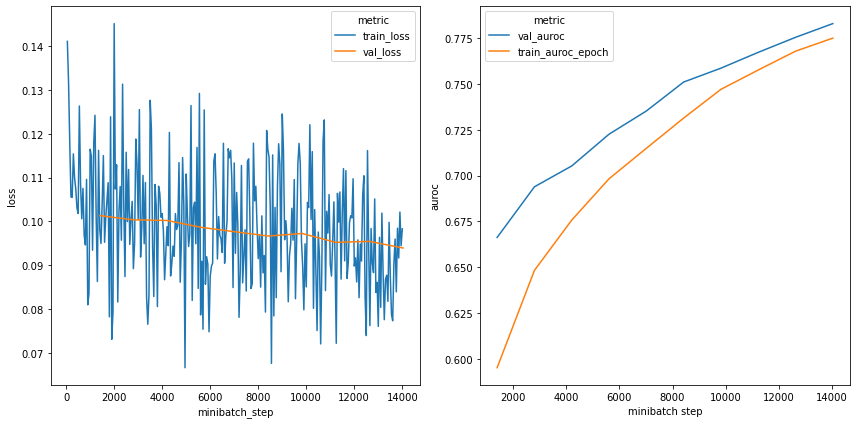

In [43]:
eu.pl.training_summary("eugene_logs/ssDeepMEL_multilabel_classification/version_4/", metric="auroc")